##  Amazon Fine Food Reviews Analysis

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:

* Apply Decision Trees on Avg-Word2Vec and tf-idf-Word2Vec(Due to low dimension).
* Apply Grid Search for finding the best max_depth.
* Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix.

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\abc\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
con = sql.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [4]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [5]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
final.shape

(364171, 10)

In [8]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True,inplace=False).reset_index(drop=True)

### Creating a subset of the data

In [9]:
final=final.iloc[:100000,:]

In [27]:
import re
import nltk
from nltk.corpus import stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned

In [ ]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [23]:
final=pd.read_pickle('100k_LR_data.pkl')

In [24]:
X = final["CleanedText"]
y = final["Score"]

### W2V Vectorization Technique

In [40]:
from gensim.models import Word2Vec
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape,X_test.shape)

(60000,) (60000,) (20000,) (20000,)


In [28]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [29]:
print(len(list_of_sent))

60000


In [30]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [31]:
w2v = list(w2v_model.wv.vocab)

In [32]:
print("number of words that occured minimum 5 times ",len(w2v))

number of words that occured minimum 5 times  10609


In [33]:
print(w2v[:50])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'use', 'seri', 'amp', 'song', 'student', 'teach']


### Average W2V

In [34]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [02:30<00:00, 398.76it/s]


60000
50


In [35]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:54<00:00, 370.23it/s]


20000
50


In [36]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_CV = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_CV): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_CV.append(sent_vec)
print(len(sent_vectors_CV))
print(len(sent_vectors_CV[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:53<00:00, 376.56it/s]


20000
50


In [37]:
X_train = sent_vectors
X_test = sent_vectors_test
X_CV= sent_vectors_CV

###  Calculate 'max_depth' using cross_validation_score


The optimal depth is 8.


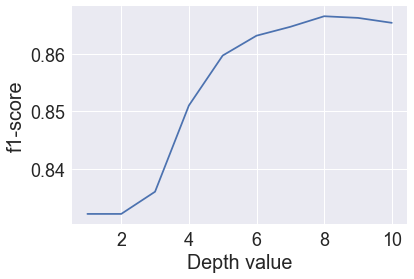

In [53]:
from sklearn.cross_validation import cross_val_score

myList = list(np.arange(1,11))



# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for depth in myList:
    DT = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(DT, X_train, y_train, cv=5, scoring='f1_weighted')
    cv_scores.append(scores.mean())

# changing to misclassification error
scr = [x for x in cv_scores]


optimal_depth = myList[scr.index(max(scr))]
print('\nThe optimal depth is %d.' % optimal_depth)

plt.plot(myList, scr)


plt.xlabel('Depth value')
plt.ylabel('f1-score')
plt.show()

Accuracy on test set: 87.015%
Precision on test set: 0.532
Recall on test set: 0.249
F1-Score on test set: 0.339
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



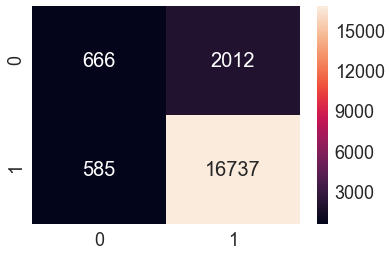

In [38]:
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

In [39]:
graph = Source( tree.export_graphviz(clf, out_file=None))
graph.format = 'png'
graph.render('dtree2_render',view=True)

'dtree2_render.png'

<img src='dtree2_render.png'>

### tf-idf W2V Vectorization Technique

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [02:59<00:00, 335.03it/s]


In [43]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:58<00:00, 342.96it/s]


In [44]:
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_CV): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 338.39it/s]


In [45]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
X_CV=tfidf_sent_vectors_CV

###  Calculate 'max_depth' using cross_validation_score


The optimal depth is 8.


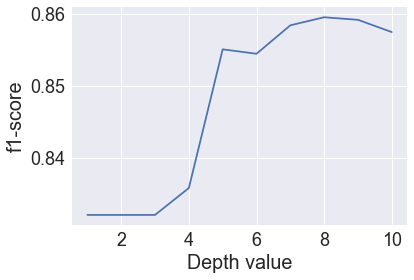

In [61]:
from sklearn.cross_validation import cross_val_score

myList = list(np.arange(1,11))


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for depth in myList:
    DT = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(DT, X_train, y_train, cv=5, scoring='f1_weighted')
    cv_scores.append(scores.mean())

# changing to misclassification error
scr = [x for x in cv_scores]


optimal_depth = myList[scr.index(max(scr))]
print('\nThe optimal depth is %d.' % optimal_depth)

plt.plot(myList, scr)


plt.xlabel('Depth value')
plt.ylabel('f1-score')
plt.show()

Accuracy on test set: 86.240%
Precision on test set: 0.465
Recall on test set: 0.183
F1-Score on test set: 0.263
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



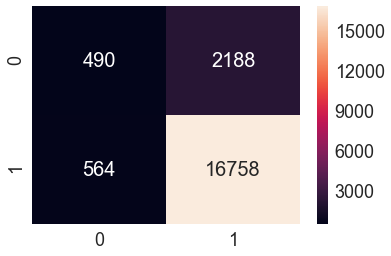

In [46]:
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

In [47]:
graph = Source( tree.export_graphviz(clf, out_file=None))
graph.format = 'png'
graph.render('dtree3_render',view=True)

'dtree3_render.png'

<img src='dtree3_render.png'>

### Bag of Words (BoW) Vectorization Technique

In [4]:
X = final["CleanedText"]
y = final["Score"]

In [3]:
final=final.iloc[:2000,:]

In [5]:
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(1600,) (1600,) (400,)


In [6]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(1200,) (1200,) (400,)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [8]:
X_test = count_vect.transform(X_test)
X_CV=count_vect.transform(X_CV)

In [9]:
X_train

<1200x7724 sparse matrix of type '<class 'numpy.int64'>'
	with 49905 stored elements in Compressed Sparse Row format>


The optimal depth is 7.


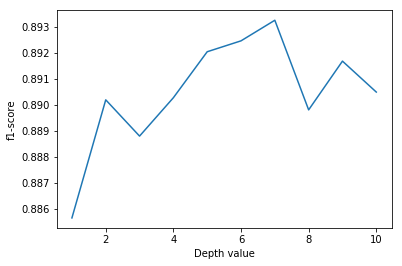

In [12]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
myList = list(np.arange(1,11))


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for depth in myList:
    DT = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(DT, X_train, y_train, cv=5, scoring='f1_weighted')
    cv_scores.append(scores.mean())

# changing to misclassification error
scr = [x for x in cv_scores]


optimal_depth = myList[scr.index(max(scr))]
print('\nThe optimal depth is %d.' % optimal_depth)

plt.plot(myList, scr)


plt.xlabel('Depth value')
plt.ylabel('f1-score')
plt.show()

Accuracy on test set: 79.000%
Precision on test set: 0.750
Recall on test set: 0.035
F1-Score on test set: 0.067
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



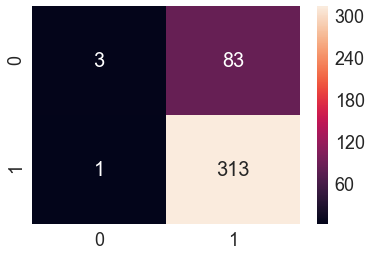

In [11]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

In [12]:
from sklearn import tree
from os import system

In [13]:
from graphviz import Source

graph = Source( tree.export_graphviz(clf, out_file=None))
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

<img src='dtree_render.png'>

### tf-idf Vectorization Technique

In [14]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(1600,) (1600,) (400,)


In [15]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(1200,) (1200,) (400,)


In [16]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [17]:
X_test=tf_idf_vect.transform(X_test)
X_CV=tf_idf_vect.transform(X_CV)

In [18]:
X_train

<1200x7724 sparse matrix of type '<class 'numpy.float64'>'
	with 49905 stored elements in Compressed Sparse Row format>


The optimal depth is 4.


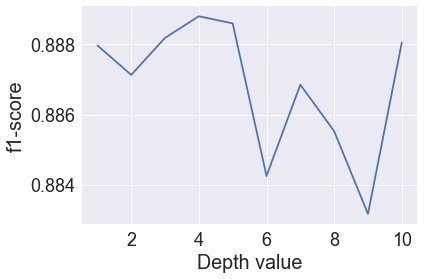

In [28]:
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for depth in myList:
    DT = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(DT, X_train, y_train, cv=5, scoring='f1_weighted')
    cv_scores.append(scores.mean())

# changing to misclassification error
scr = [x for x in cv_scores]


optimal_depth = myList[scr.index(max(scr))]
print('\nThe optimal depth is %d.' % optimal_depth)

plt.plot(myList, scr)


plt.xlabel('Depth value')
plt.ylabel('f1-score')
plt.show()

Accuracy on test set: 77.500%
Precision on test set: 0.167
Recall on test set: 0.012
F1-Score on test set: 0.022
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



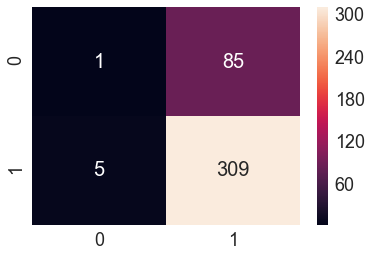

In [19]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

In [20]:
graph = Source( tree.export_graphviz(clf, out_file=None))
graph.format = 'png'
graph.render('dtree1_render',view=True)

'dtree1_render.png'

<img src='dtree1_render.png'>

In [48]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [49]:
x.field_names = ["Vectorization_Technique", "Depth_value", "F1-Score", "Accuracy(%)"]

In [50]:
x.add_row(["Average W2V", "9" ,0.339,87.015])

In [51]:
x.add_row(["tf-idf W2V","8" ,0.263, 86.240])

In [52]:
x.add_row(["BOW", "7" , 0.067, 79.000])

In [53]:
x.add_row(["tf-idf", "4" ,0.022,77.500])

In [54]:
print(x)

+-------------------------+-------------+----------+-------------+
| Vectorization_Technique | Depth_value | F1-Score | Accuracy(%) |
+-------------------------+-------------+----------+-------------+
|       Average W2V       |      9      |  0.339   |    87.015   |
|        tf-idf W2V       |      8      |  0.263   |    86.24    |
|           BOW           |      7      |  0.067   |     79.0    |
|          tf-idf         |      4      |  0.022   |     77.5    |
+-------------------------+-------------+----------+-------------+


## Conclusions

* Average W2V Featurization(max_depth=9) gave the best results with accuracy of 86.485% and F1-score of 0.330 